In [1]:
from imports import *
from exactDiagMethods import build_exact_diag_hamiltonian, perform_exact_diag
from globalMethods import  build_initial_states, output_results
from vqteMethods import hamiltonian_generation, perform_vqte

# Don't forget to make F_L, F_R lists
# Make everything work with eps list
# Comment and delete old methods
# Make sure all imports are relevant


In [ ]:
def main():
    # Initialize the simulation parameters
    N = 2
    gamma_L= 1.0
    gamma_R = 1.0
    eps = 1
    mu_L= 1
    mu_R= 1
    T_L = 10   
    T_R= 100
    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)
    J = 1

    eps_list = []

    for i in range(N):
        eps_list.append(1)

  
    time = 6.0
    dt = 0.5
    nt = int(time/dt)

    

 

    exact_diag_ham = build_exact_diag_hamiltonian(J, eps_list)

    print("Exact Ham", exact_diag_ham)

   #printexact_diag_hamiltonian)
    ham_real, ham_imag = hamiltonian_generation(N, eps_list, gamma_L, gamma_R, F_L, F_R,J)
    print("Ham imag", ham_imag)
    print("Ham real", ham_real)

    # exact_diag_results, time_points = [],[]

    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)


    exact_diag_results, time_points = perform_exact_diag(gamma_L,F_L, gamma_R, F_R, dt, nt, exact_diag_init_state,exact_diag_ham, N)

 
    vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values,N)
    
    # # Output results
    output_results(vqte_results, exact_diag_results, time, nt, time_points)

Exact Init State:  [[ 0.09549106-1.26395749e-18j -0.09344051+2.90884215e-02j
  -0.17127396-6.90000346e-02j  0.16443547+1.25141718e-01j]
 [-0.09344051-2.90884215e-02j  0.1002949 -1.50136537e-18j
   0.14657734+1.19691711e-01j -0.12278385-1.72544691e-01j]
 [-0.17127396+6.90000346e-02j  0.14657734-1.19691711e-01j
   0.35705726-7.54366721e-19j -0.38535858-1.05637794e-01j]
 [ 0.16443547-1.25141718e-01j -0.12278385+1.72544691e-01j
  -0.38535858+1.05637794e-01j  0.44715679-2.43268565e-18j]]
Exact initial state: [[ 0.09549106-1.26395749e-18j -0.09344051+2.90884215e-02j
  -0.17127396-6.90000346e-02j  0.16443547+1.25141718e-01j]
 [-0.09344051-2.90884215e-02j  0.1002949 -1.50136537e-18j
   0.14657734+1.19691711e-01j -0.12278385-1.72544691e-01j]
 [-0.17127396+6.90000346e-02j  0.14657734-1.19691711e-01j
   0.35705726-7.54366721e-19j -0.38535858-1.05637794e-01j]
 [ 0.16443547-1.25141718e-01j -0.12278385+1.72544691e-01j
  -0.38535858+1.05637794e-01j  0.44715679-2.43268565e-18j]]
Initial expectation va

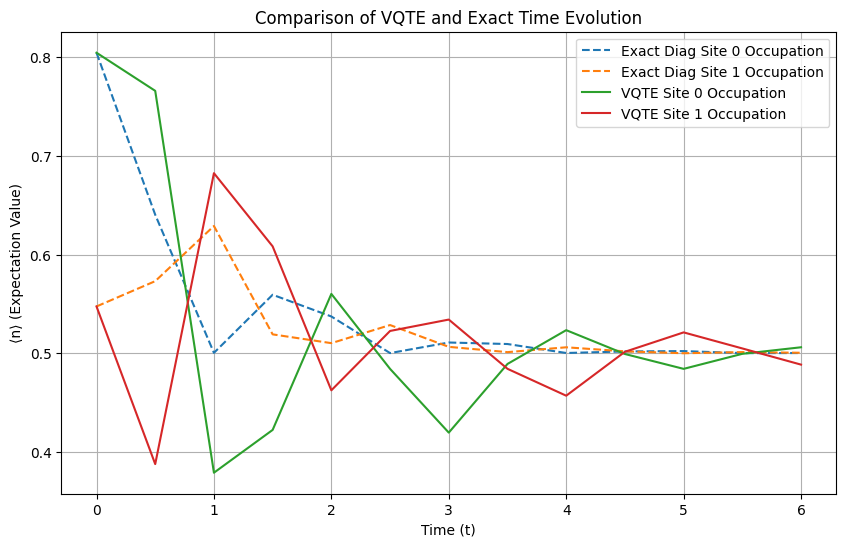

In [3]:
main()